# Data Pipelining

In [34]:
!pip install pandas numpy geopandas seaborn scikit-learn tensor folium folium matplotlib mapclassify earthengine-api geemap pyarrow xgboost

In [35]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import pprint
import geemap
import ee
import folium

In [36]:
#Bringing in the original data frame

In [37]:
#Make sure the correct path to the classification_plots.zip is in the folder directory for the code to work efficient

In [38]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf = gpd.read_file('Classification_Plots.zip')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf.crs)
display(gdf.columns)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Index(['Source.Nam', 'plotid', 'sampleid', 'lon', 'lat', 'sample_geo', 'Uso',
       'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo',
       'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_',
       'Gana_Perdi', 'geometry'],
      dtype='object')

In [39]:
k_clms = ['plotid','sampleid','Uso','Cobertura','Vegetacion','Herbaceas', 'Pasto_Arb', 'Cultivo','Humedal', 'Terreno','Agua','Otra_clase','SAF','Cambios15_','Gana_Perdi','geometry']
gdf1=gdf[k_clms]
#K columns is a list of column names we want to analyse  
#so we are creating a sub dataframe 

In [40]:
# Columns to replace NA values
sp_columns_to_replace = ['Uso', 'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_', 'Gana_Perdi']
en_columns_to_replace = ['Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss']

# Replace NA values with "Not_Applicable"
gdf1[sp_columns_to_replace] = gdf1[sp_columns_to_replace].fillna("No_Aplicable")

# Prints the NA count for column with NA values, just to double check
na_count = gdf1.isna().sum()
print(na_count)

plotid        0
sampleid      0
Uso           0
Cobertura     0
Vegetacion    0
Herbaceas     0
Pasto_Arb     0
Cultivo       0
Humedal       0
Terreno       0
Agua          0
Otra_clase    0
SAF           0
Cambios15_    0
Gana_Perdi    0
geometry      0
dtype: int64


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Now that we've cleaned the data from all NA values, and removed our duplicate quality control/quality assurance entires, let's save this dataset

In [41]:
#This code saves the dataframe 
#test = gpd.read_parquet('../Costa_Rica_Data/Setup Output/sp_setup_data.parquet')

In [42]:
# Saves the Spanish (original language) dataframe as a parquet file
#gdf1.to_parquet("./sp_clean_classification_data.parquet", engine="pyarrow")

In [43]:
# Create a makeshift subset of the original GeoDataFrame
downsampled_gdf = gdf1.iloc[::9]

# Calculate the mean geometric point to center the map
mean_point = downsampled_gdf.geometry.union_all().centroid
mean_lat, mean_lon = mean_point.y, mean_point.x

# Initialize a Folium map centered on the mean geometric point
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=9)

# Add each point from the downsampled GeoDataFrame to the map
for _, row in downsampled_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1,  # Smaller radius for points
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7
    ).add_to(m)

# Display the map
display(m)

We extracted the medoid values for each point. The medoid values help describe the point numerically [gee extraction](John-CostaRica.ipynb)

In [44]:
# The output of John's Code (Spanish version)
gdf2 = gpd.read_parquet('en_basic_gee_data (1).parquet')
gdf2.head()

plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    lai    mTPI      ndvi ocs_1mMed sand_1mMed  \
9   Not_Applicable  ...  0.305  8129.0  0.799771      68.0     332.15   
12  Not_Applicable  ...  0.305  8129.0  0.796553      68.0     332.15   
13  Not_Applicable  ...  0.260  8129.0  0.644415      65.0     340.45   
15  Not_Applicable  ...  0.305  8129.0  0.784331      68.0     332.15   
16  Not_Applicable  ...  0.260  8129.0  0.769357      65.0     340.45   

        savi  silt_1mMed     slope       topDiv   wetness  
9   0.393728      298.85  0.927410  1323.685053 -0.006312  
12  0.423713      298.85  2.935819  1323.685053 -0.014932  
13  0.380250      304.70  0.944368  1323.685053 -0.001697  
15  0.512687      298.85  0.927410  1323.685053 -0.027987  
16  0.360428      304.70  2.645556  1323.685053 -0.009912  

[5 rows x 44 columns]

# Data Cleaning

In [12]:
# Prints the NA count for column with NA values
na_count = gdf2.isna().sum()
print(na_count[na_count > 0])

BLUE            30
GREEN           26
NIR             26
RED             26
SWIR1           26
SWIR2           26
altura2       3527
brightness      26
diff            26
evi             30
hand30_100       3
mTPI           157
ndvi           339
savi            26
topDiv         157
wetness         26
dtype: int64


In [13]:
# Filling all the numeric values that are missing with the mean from the column
columns_to_fill = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'diff', 'evi', 'hand30_100','mTPI', 'ndvi', 'savi', 'topDiv','wetness']  # Specify the columns to fill
for column in columns_to_fill:
    gdf2[column] = gdf2[column].fillna(gdf2[column].mean())
    gdf2[column] = gdf2[column].fillna(gdf2[column].mean())

In [14]:
# Prints the NA count for column with NA values
na_count = gdf2.isna().sum()
print(na_count[na_count > 0])

Series([], dtype: int64)


In [15]:
gdf2.head(5)

plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    lai    mTPI      ndvi ocs_1mMed sand_1mMed  \
9   Not_Applicable  ...  0.305  8129.0  0.799771      68.0     332.15   
12  Not_Applicable  ...  0.305  8129.0  0.796553      68.0     332.15   
13  Not_Applicable  ...  0.260  8129.0  0.644415      65.0     340.45   
15  Not_Applicable  ...  0.305  8129.0  0.784331      68.0     332.15   
16  Not_Applicable  ...  0.260  8129.0  0.769357      65.0     340.45   

        savi  silt_1mMed     slope       topDiv   wetness  
9   0.393728      298.85  0.927410  1323.685053 -0.006312  
12  0.423713      298.85  2.935819  1323.685053 -0.014932  
13  0.380250      304.70  0.944368  1323.685053 -0.001697  
15  0.512687      298.85  0.927410  1323.685053 -0.027987  
16  0.360428      304.70  2.645556  1323.685053 -0.009912  

[5 rows x 44 columns]

# Exploritory Data Analysis 

The exploritory data analysis is for the data scientist to investigate the data and have a better understanding of what the variables mean. This helps the feature selection process which is then fed to the modeling process. 
The normalized difference vegetation index (NDVI) is a simple graphical indication that may be used to analyse remote sensing data, often from a space platform, to determine whether or not the objective under observation has living green vegetation.

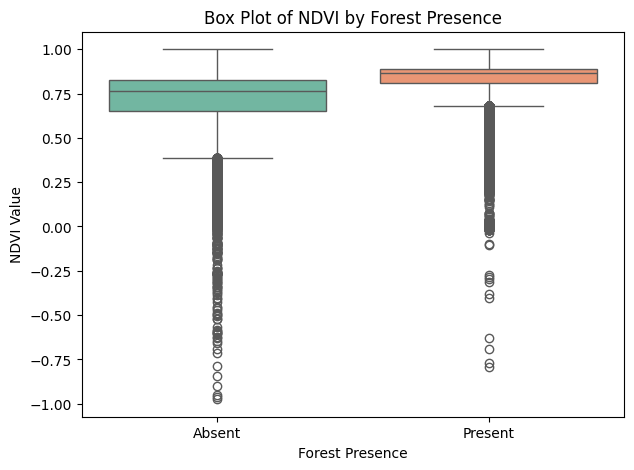

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a new column indicating 'Forest Present' or 'Absent'
gdf2['Forest_Presence'] = gdf2['Use'].apply(lambda x: 'Present' if x in ['Forest', 'Pasture ', 'Agriculture', 'Forest Plantation', 'WetLand'] else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [17]:
#We are checking all the values that have a absents in forest
absent_use_values = gdf2[gdf2['Forest_Presence'] == 'Absent']['Use']
print(absent_use_values)

9           Wetlands
12        Grasslands
13          Wetlands
15        Grasslands
16          Wetlands
             ...    
101124    Grasslands
101125    Grasslands
101127    Grasslands
101128    Grasslands
101130    Grasslands
Name: Use, Length: 31412, dtype: object


In [18]:
#We are displaying the values in the absent section to learn what values it has 
unique_absent_use_values = absent_use_values.unique()
print(unique_absent_use_values)
use_counts = absent_use_values.value_counts()
print(use_counts)

['Wetlands' 'Grasslands' 'Other classes' 'Forest plantation'
 'No information' 'Not_Applicable']
Use
Grasslands           21793
Other classes         4732
Wetlands              3659
Forest plantation      838
No information         219
Not_Applicable         171
Name: count, dtype: int64


In [19]:
high_ndvi_absent = gdf2[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33)]

# Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()
print(mean_ndvi_by_vegetation)

Vegetations
Herbaceous plants    0.738340
Not_Applicable       0.656511
Other vegetation     0.780386
Palms                0.853307
Shrubs               0.778165
Trees                0.796857
Name: ndvi, dtype: float64


As part of our exploratory data analysis, we are examining NDVI by setting thresholds to better understand its behavior. These thresholds allow us to observe why certain areas have high NDVI values, which typically indicate the presence of vegetation. However, we want to explore whether NDVI can be interpreted beyond just forest presence. Even in areas without dense forests, we still observe vegetation such as palms, shrubs, and smaller trees. By analyzing these variations, we aim to refine how NDVI is used in vegetation classification and assess whether it can be improved or complemented with other metrics.

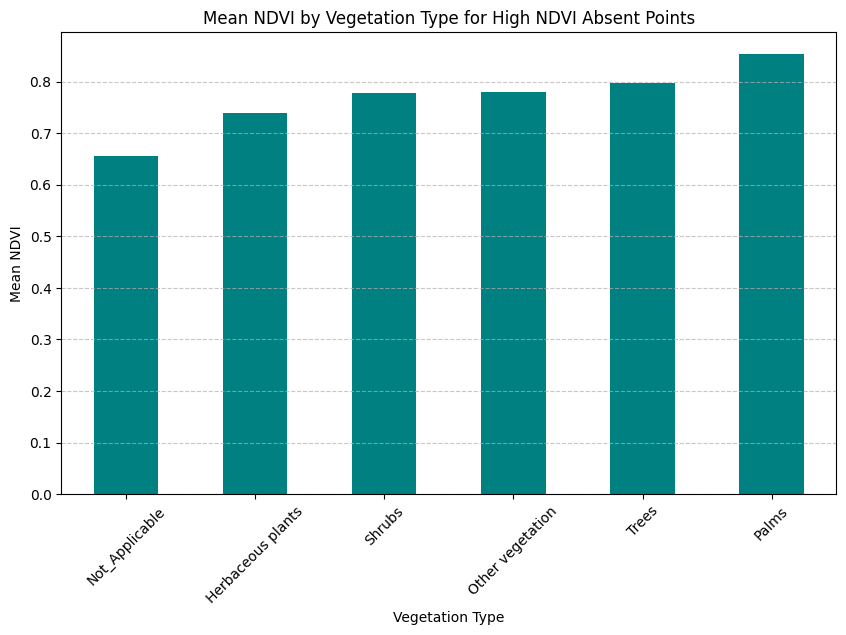

In [20]:


# Filter and group by 'Vegetation', calculating the mean NDVI
high_ndvi_absent = gdf2[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33)]
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_by_vegetation.sort_values().plot(kind='bar', color='teal')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for High NDVI Absent Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

We can say they NDVI is associated with greenery because a high NDVI indicates vegetation and the averge ndvi here is pretty high. Since a high ndvi represents vegetation or green on a map what if we take out all the ndvi scores below 33% and see how our data changes.

In [21]:
gdf2.loc[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33), 'Forest_Presence'] = 'Present'

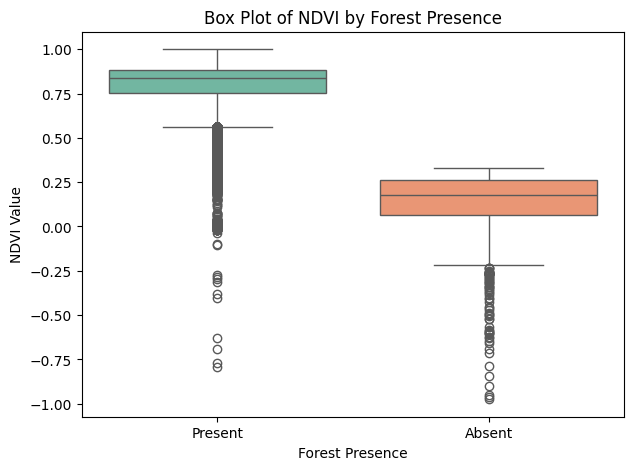

In [22]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

So now I am sayng that there is a column in my df called forest_presents and if the ndvi is lower then 33% then that means there is forest absence.


In [23]:
q1 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

print(f"Low NDVI Outlier Threshold: {low_outlier_threshold}")
#To ensure the accuracy of our forest classification, we analyzed NDVI values for areas labeled as 'Present' in the Forest_Presence 
#column. Using the interquartile range (IQR) method, we identified a threshold for unusually low NDVI values that might indicate
#potential misclassifications or anomalies. Any NDVI value below this threshold is considered a low NDVI outlier, which could suggest mislabeled forest areas 
#or regions with sparse vegetation. This analysis helps refine our classification and improve the reliability of NDVI as an indicator of forest presence.

Low NDVI Outlier Threshold: 0.5611601201579609


In [24]:
low_ndvi_outliers = gdf2[(gdf2['Forest_Presence'] == 'Present') & (gdf2['ndvi'] < low_outlier_threshold)]
low_ndvi_outliers
#We are checking to see if the use values are some kind of green or forest when the NDVI is lower then usual. 

plotid  sampleid            Use      CoverType     Vegetations  \
18        2903     11609  Other classes  No vegetation  Not_Applicable   
19        2903     11610  Other classes  No vegetation  Not_Applicable   
63        2960     11837       Wetlands          Water  Not_Applicable   
66        2960     11840       Wetlands          Water  Not_Applicable   
67        2960     11841       Wetlands          Water  Not_Applicable   
...        ...       ...            ...            ...             ...   
101084  906847   3627390         Forest     Vegetation           Trees   
101085  906847   3627391         Forest     Vegetation           Trees   
101086  906847   3627392         Forest     Vegetation           Trees   
101087  906847   3627393         Forest     Vegetation           Trees   
101151  904894   3619573         Forest     Vegetation           Trees   

            Herbaceous  GrasslandShrub       CropsType     WetlandArea  \
18      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
19      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
63      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
66      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
67      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
...                ...             ...             ...             ...   
101084  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101085  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101086  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101087  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101151  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   

              LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
18      Other surfaces  ...  8132.0  0.528579      63.0     336.45  0.295504   
19      Other surfaces  ...  8132.0  0.437536      63.0     336.45  0.152839   
63      Not_Applicable  ...  8127.0  0.503759      58.0     264.65  0.249684   
66      Not_Applicable  ...  8127.0  0.421427      58.0     264.65  0.172648   
67      Not_Applicable  ...  8127.0  0.451770      58.0     264.65  0.212015   
...                ...  ...     ...       ...       ...        ...       ...   
101084  Not_Applicable  ...  8157.0 -0.010946     132.0     321.90 -0.012102   
101085  Not_Applicable  ...  8232.0 -0.010758     132.0     323.55 -0.011875   
101086  Not_Applicable  ...  8232.0 -0.011036     132.0     321.90 -0.012187   
101087  Not_Applicable  ...  8157.0 -0.010568     132.0     321.90 -0.011680   
101151  Not_Applicable  ...  8137.0 -0.008563     126.0     296.95 -0.010184   

       silt_1mMed      slope       topDiv   wetness  Forest_Presence  
18         265.70   7.437723  1323.698838 -0.032052          Present  
19         265.70   2.645458  1323.698838 -0.016620          Present  
63         268.00   3.382467  1323.673565 -0.056526          Present  
66         268.00   0.000000  1323.673565 -0.026745          Present  
67         268.00   0.000000  1323.673565 -0.072998          Present  
...           ...        ...          ...       ...              ...  
101084     333.90  55.651031  1324.630000  0.455953          Present  
101085     324.50  37.565701  1324.630000  0.467968          Present  
101086     333.90  53.213791  1324.630000  0.462251          Present  
101087     333.90  49.832008  1324.630000  0.460804          Present  
101151     354.95  32.235409  1324.494757  0.537303          Present  

[5546 rows x 45 columns]

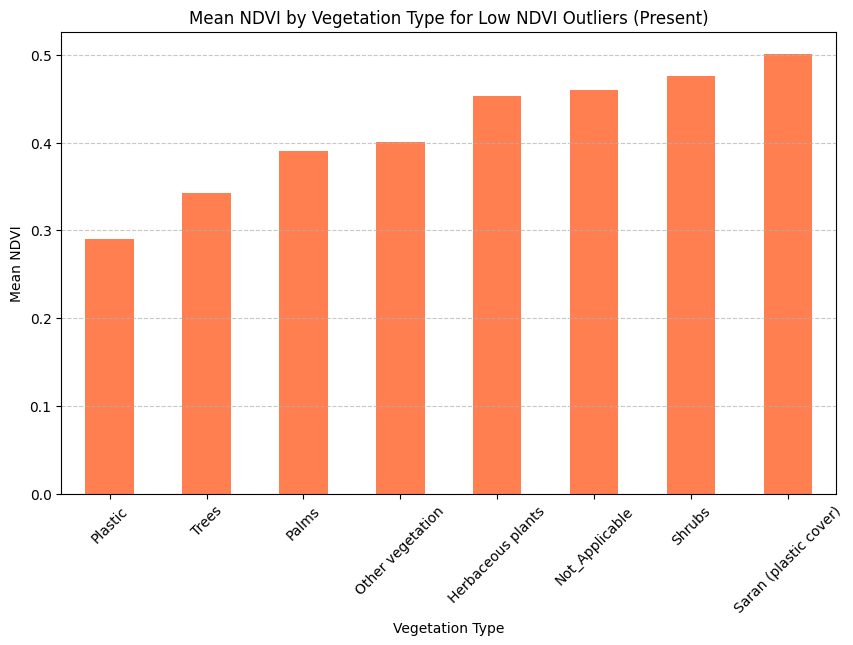

In [25]:
# Step 1: Calculate the IQR and identify low NDVI outliers for 'Present' Forest_Presence
q1 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

# Step 2: Filter the low NDVI outliers
low_ndvi_outliers = gdf2[(gdf2['Forest_Presence'] == 'Present') & (gdf2['ndvi'] < low_outlier_threshold)]

# Step 3: Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_outliers_by_vegetation = low_ndvi_outliers.groupby('Vegetations')['ndvi'].mean()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_outliers_by_vegetation.sort_values().plot(kind='bar', color='coral')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for Low NDVI Outliers (Present)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


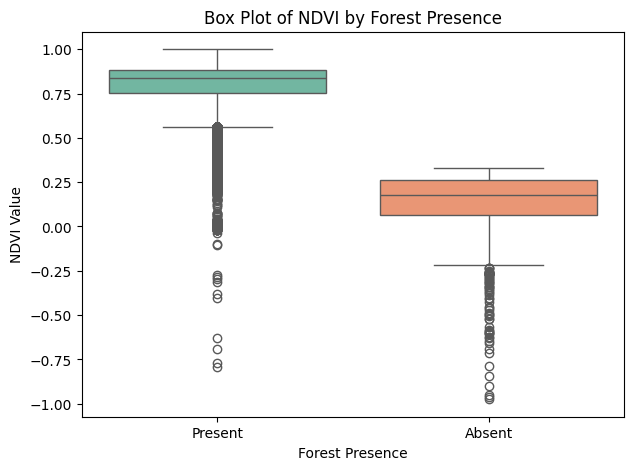

    plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
9   Not_Applicable  ...  8129.0  0.799771      68.0 

In [26]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()
print(gdf2.head())

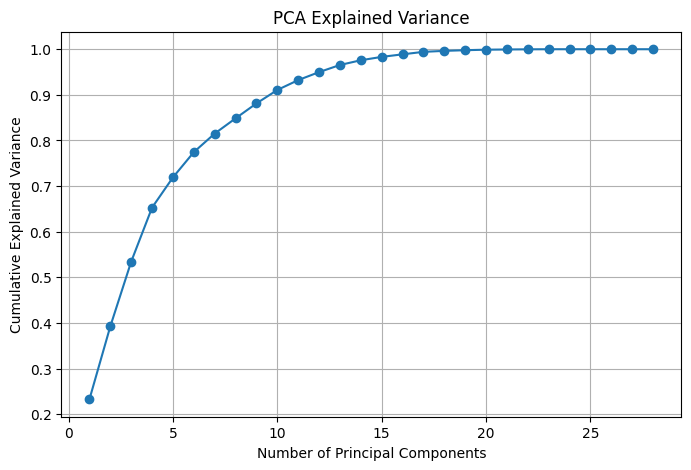

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
features = gdf2.drop(['Forest_Presence', 'plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry'], axis=1)  # Adjust columns as needed
features_scaled = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [28]:
# Retain the first 9 or 10 components
n_components = 12  # or 9, depending on how much variance you want to retain
reduced_data = principal_components[:, :n_components]

# Convert it back to a DataFrame for easier handling
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Add your target variable (Forest_Presence) back to the reduced dataset if needed
reduced_df['Forest_Presence'] = gdf2['Forest_Presence'].values

# Show the first few rows of the reduced data
print(reduced_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.293332 -1.837715 -1.221866  0.262553  0.759845  1.780217  0.715952   
1 -0.298827 -3.020864  0.753586  1.986402  0.310587  1.303170  0.680551   
2  1.477013 -0.566561 -1.675973 -0.814450  0.721028  1.742934  0.629332   
3  1.606029  1.631651 -3.048346 -0.420528 -0.138250  0.868924  0.487024   
4 -0.496026 -3.593084  0.269709  1.192702  0.636611  1.702571  0.749179   

        PC8       PC9      PC10      PC11      PC12 Forest_Presence  
0  0.050124  0.164082  0.032083  0.256864 -0.406719         Present  
1 -0.121381  0.226985 -0.038734  0.202894 -0.409633         Present  
2 -0.085434  0.293895  0.075413  0.374638 -0.168606         Present  
3 -0.207749  0.185173 -0.091955  0.131265 -0.398700         Present  
4 -0.086336  0.361164 -0.057432  0.416056 -0.186218         Present  


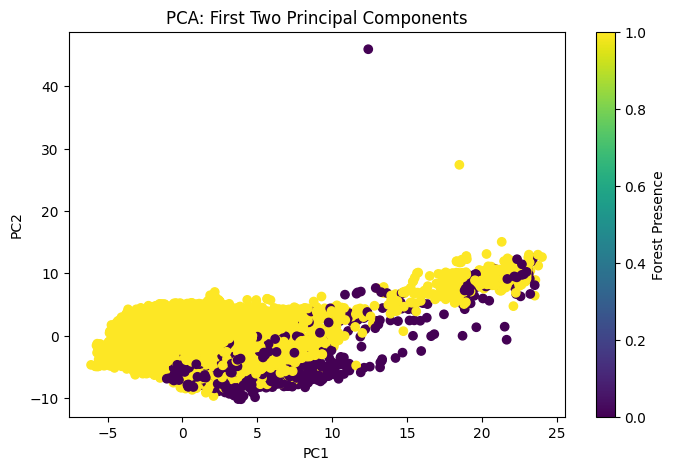

In [29]:
# Visualize the first two principal components
plt.figure(figsize=(8, 5))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Forest_Presence'].map({'Present': 1, 'Absent': 0}), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Forest Presence')
plt.show()

# Feature Selection and Modeling (adams version)

<BarContainer object of 2 artists>

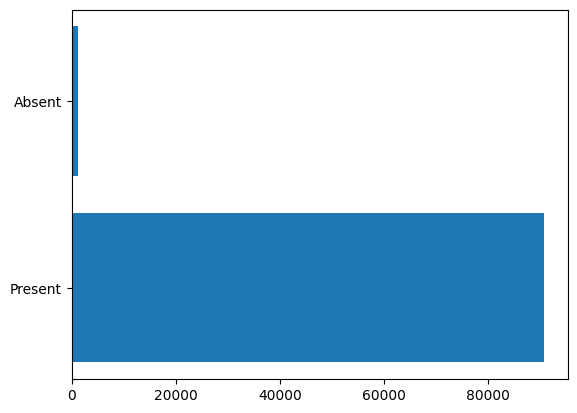

In [30]:
mycounts = reduced_df['Forest_Presence'].value_counts()
# now we sort them and find the highest 10
#then plot
import matplotlib.pyplot as plt
plt.barh(mycounts.index, mycounts)

In [31]:
columns_to_add = ['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations',
                  'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 
                  'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 
                  'Gain_Loss', 'geometry']

# Assuming gdf2 is your original DataFrame with all the columns
for col in columns_to_add:
    reduced_df[col] = gdf2[col].values
print(reduced_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.293332 -1.837715 -1.221866  0.262553  0.759845  1.780217  0.715952   
1 -0.298827 -3.020864  0.753586  1.986402  0.310587  1.303170  0.680551   
2  1.477013 -0.566561 -1.675973 -0.814450  0.721028  1.742934  0.629332   
3  1.606029  1.631651 -3.048346 -0.420528 -0.138250  0.868924  0.487024   
4 -0.496026 -3.593084  0.269709  1.192702  0.636611  1.702571  0.749179   

        PC8       PC9      PC10  ...          GrasslandShrub       CropsType  \
0  0.050124  0.164082  0.032083  ...          Not_Applicable  Not_Applicable   
1 -0.121381  0.226985 -0.038734  ...  Mixed Pasture (70-90%)  Not_Applicable   
2 -0.085434  0.293895  0.075413  ...          Not_Applicable  Not_Applicable   
3 -0.207749  0.185173 -0.091955  ...  Mixed Pasture (70-90%)  Not_Applicable   
4 -0.086336  0.361164 -0.057432  ...          Not_Applicable  Not_Applicable   

      WetlandArea        LandType   WaterBodyType      OtherClass  \

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Setup
categorical_columns = ['Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub',
                       'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass',
                       'SAF', 'Changes_15', 'Gain_Loss']

# Features from PCA
feature_columns = [f'PC{i}' for i in range(1, 13)]
X = reduced_df[feature_columns]

# Store results
rf_results = {}
xgb_results = {}
encoders = {}

# Loop over each target column
for col in categorical_columns:
    print(f"\nTraining for column: {col}")
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(reduced_df[col])
    encoders[col] = le  # Save encoder for decoding later

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)

    # Train XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)

    # Evaluate
    rf_acc = accuracy_score(y_test, rf_preds)
    rf_f1 = f1_score(y_test, rf_preds, average='weighted')
    
    xgb_acc = accuracy_score(y_test, xgb_preds)
    xgb_f1 = f1_score(y_test, xgb_preds, average='weighted')

    # Store results
    rf_results[col] = {'model': rf_model, 'accuracy': rf_acc, 'f1': rf_f1, 'preds': rf_preds}
    xgb_results[col] = {'model': xgb_model, 'accuracy': xgb_acc, 'f1': xgb_f1, 'preds': xgb_preds}

    print(f"RF - Accuracy: {rf_acc:.4f}, F1 Score: {rf_f1:.4f}")
    print(f"XGB - Accuracy: {xgb_acc:.4f}, F1 Score: {xgb_f1:.4f}")



Training for column: Use


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:08:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.7833, F1 Score: 0.7714
XGB - Accuracy: 0.7607, F1 Score: 0.7500

Training for column: CoverType


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:09:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9496, F1 Score: 0.9356
XGB - Accuracy: 0.9493, F1 Score: 0.9367

Training for column: Vegetations


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:09:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.7804, F1 Score: 0.7609
XGB - Accuracy: 0.7650, F1 Score: 0.7454

Training for column: Herbaceous


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:10:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.8336, F1 Score: 0.8215
XGB - Accuracy: 0.8193, F1 Score: 0.8089

Training for column: GrasslandShrub


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:11:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.8123, F1 Score: 0.7763
XGB - Accuracy: 0.7898, F1 Score: 0.7502

Training for column: CropsType


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:12:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9435, F1 Score: 0.9292
XGB - Accuracy: 0.9451, F1 Score: 0.9331

Training for column: WetlandArea


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:12:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9739, F1 Score: 0.9679
XGB - Accuracy: 0.9743, F1 Score: 0.9700

Training for column: LandType


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:13:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9552, F1 Score: 0.9396
XGB - Accuracy: 0.9549, F1 Score: 0.9402

Training for column: WaterBodyType


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:14:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9960, F1 Score: 0.9955
XGB - Accuracy: 0.9962, F1 Score: 0.9959

Training for column: OtherClass


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:14:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9559, F1 Score: 0.9410
XGB - Accuracy: 0.9564, F1 Score: 0.9432

Training for column: SAF


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:15:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9458, F1 Score: 0.9342
XGB - Accuracy: 0.9450, F1 Score: 0.9344

Training for column: Changes_15


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.8975, F1 Score: 0.8566
XGB - Accuracy: 0.8939, F1 Score: 0.8503

Training for column: Gain_Loss


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:17:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RF - Accuracy: 0.9649, F1 Score: 0.9487
XGB - Accuracy: 0.9652, F1 Score: 0.9496


In [33]:
# Generate sample descriptions for first 10 test samples
print("\nSample Descriptions (using Random Forest predictions):")
for i in range(10):
    desc = []
    for col in categorical_columns:
        pred_value = rf_results[col]['preds'][i]
        label = encoders[col].inverse_transform([pred_value])[0]
        if label != 'Not_Applicable':
            desc.append(f"{col}: {label}")
    print(f"Point {i+1} - " + ", ".join(desc))



Sample Descriptions (using Random Forest predictions):
Point 1 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 2 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 3 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 4 - Use: Grasslands, CoverType: Vegetation, Vegetations: Herbaceous plants, Herbaceous: Grasses, GrasslandShrub: Combined Pasture (50-70%), Changes_15: No
Point 5 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 6 - Use: Grasslands, CoverType: Vegetation, Vegetations: Herbaceous plants, Herbaceous: Grasses, GrasslandShrub: Mixed Pasture (70-90%), Changes_15: No
Point 7 - Use: Wetlands, CoverType: Vegetation, Vegetations: Palms, WetlandArea: Yolillal_Plants, Changes_15: No
Point 8 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 9 - Use: Forest, CoverType: Vegetation, Vegetations: Trees, Changes_15: No
Point 10 - Use: Forest, Co

## Modeling Waynes

In [45]:
data = gpd.read_parquet('en_basic_gee_data (1).parquet')

In [46]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns (object or string types)
cat_cols = data.select_dtypes(exclude=['number']).columns

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode each categorical column, handling encoding errors
for col in cat_cols:
    # Exclude 'geometry' column from label encoding
    if col == 'geometry':
        continue
    try:
        data[col] = label_encoder.fit_transform(data[col].astype(str))
    except UnicodeDecodeError:
        # If UnicodeDecodeError occurs, try decoding with 'latin-1' before encoding
        data[col] = label_encoder.fit_transform(data[col].astype(str).str.decode('latin-1', errors='ignore'))  # Decode before encoding

print("✅ All categorical columns have been label encoded.")
print("Encoded columns:", list(cat_cols))

✅ All categorical columns have been label encoded.
Encoded columns: ['Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry']


In [47]:
compressed_data = data.copy()

In [49]:
compressed_data = compressed_data.drop(["Vegetations", "Herbaceous", "GrasslandShrub", "CropsType", "WetlandArea", "LandType", "WaterBodyType", "OtherClass", "SAF", "Changes_15", "Gain_Loss", "geometry",'plotid',"sampleid","Use"], axis=1)
     

In [50]:
compressed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91917 entries, 9 to 101159
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CoverType   91917 non-null  int64  
 1   BLUE        91887 non-null  float64
 2   GREEN       91891 non-null  float64
 3   NIR         91891 non-null  float64
 4   RED         91891 non-null  float64
 5   SWIR1       91891 non-null  float64
 6   SWIR2       91891 non-null  float64
 7   altura2     88390 non-null  float64
 8   aspect      91917 non-null  float64
 9   aspectcos   91917 non-null  float64
 10  aspectdeg   91917 non-null  float64
 11  aspectsin   91917 non-null  float64
 12  brightness  91891 non-null  float64
 13  clay_1mMed  91917 non-null  float64
 14  diff        91891 non-null  float64
 15  elevation   91917 non-null  float64
 16  evi         91887 non-null  float64
 17  fpar        91917 non-null  float64
 18  hand30_100  91914 non-null  float64
 19  lai         91917 non-null  f

## Will try three different techniciques to reduce the number of features for our model.

A simple target and features correlation matrix 2.Feature Importance from Random Forest / Tree Models 3.Recursive Feature Elimination

In [51]:
compressed_data.corr(numeric_only=True)['CoverType'].sort_values(ascending=False)

CoverType     1.000000
ndvi          0.250396
fpar          0.213624
wetness       0.190853
lai           0.182559
savi          0.178643
altura2       0.166989
diff          0.140854
silt_1mMed    0.120936
ocs_1mMed     0.114321
sand_1mMed    0.100925
slope         0.088565
clay_1mMed    0.088378
topDiv        0.080124
evi           0.060580
NIR           0.060356
hand30_100    0.056624
elevation     0.010221
mTPI          0.004392
aspectcos     0.000710
aspectdeg    -0.003068
aspect       -0.003068
aspectsin    -0.008108
BLUE         -0.056562
brightness   -0.073112
GREEN        -0.078330
RED          -0.125854
SWIR1        -0.157526
SWIR2        -0.230077
Name: CoverType, dtype: float64

In [52]:
# We will take the predictors that correlation is atleast 0.05 are greater errir spective of the sign negative
# lets store the correlation in a variable
corr_matrix = compressed_data.corr(numeric_only=True)['CoverType']
print(corr_matrix)

CoverType     1.000000
BLUE         -0.056562
GREEN        -0.078330
NIR           0.060356
RED          -0.125854
SWIR1        -0.157526
SWIR2        -0.230077
altura2       0.166989
aspect       -0.003068
aspectcos     0.000710
aspectdeg    -0.003068
aspectsin    -0.008108
brightness   -0.073112
clay_1mMed    0.088378
diff          0.140854
elevation     0.010221
evi           0.060580
fpar          0.213624
hand30_100    0.056624
lai           0.182559
mTPI          0.004392
ndvi          0.250396
ocs_1mMed     0.114321
sand_1mMed    0.100925
savi          0.178643
silt_1mMed    0.120936
slope         0.088565
topDiv        0.080124
wetness       0.190853
Name: CoverType, dtype: float64


In [53]:
features_to_drop =  corr_matrix[abs(corr_matrix) < 0.05].index
print(features_to_drop)


Index(['aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'elevation', 'mTPI'], dtype='object')


In [54]:
# now we take the orignal dataframe an the drop features and compare to get a new list
correlation_final=[]
for i in compressed_data:
  if i not in features_to_drop:
     correlation_final.append(i)
print(correlation_final)


['CoverType', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'clay_1mMed', 'diff', 'evi', 'fpar', 'hand30_100', 'lai', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness']


## I chose to drop features that had an absolute value below a 0.05 % significance level.Using list compreshion the features: 'plotid', 'sampleid', 'aspect', 'aspectcos', 'aspectdeg', 'aspectsin','elevation', 'mTPI'.These are the potential features to be dropped usng a simple correlation approach.

## Feature Importance from Random Forest / Tree Models

Training Accuracy: 1.00
Test Accuracy: 0.95
       Feature  Importance
20        ndvi    0.063601
15         evi    0.051828
23        savi    0.047823
6      altura2    0.045370
12  clay_1mMed    0.043313
22  sand_1mMed    0.042053
21   ocs_1mMed    0.040745
0         BLUE    0.039822
3          RED    0.038477
5        SWIR2    0.037983


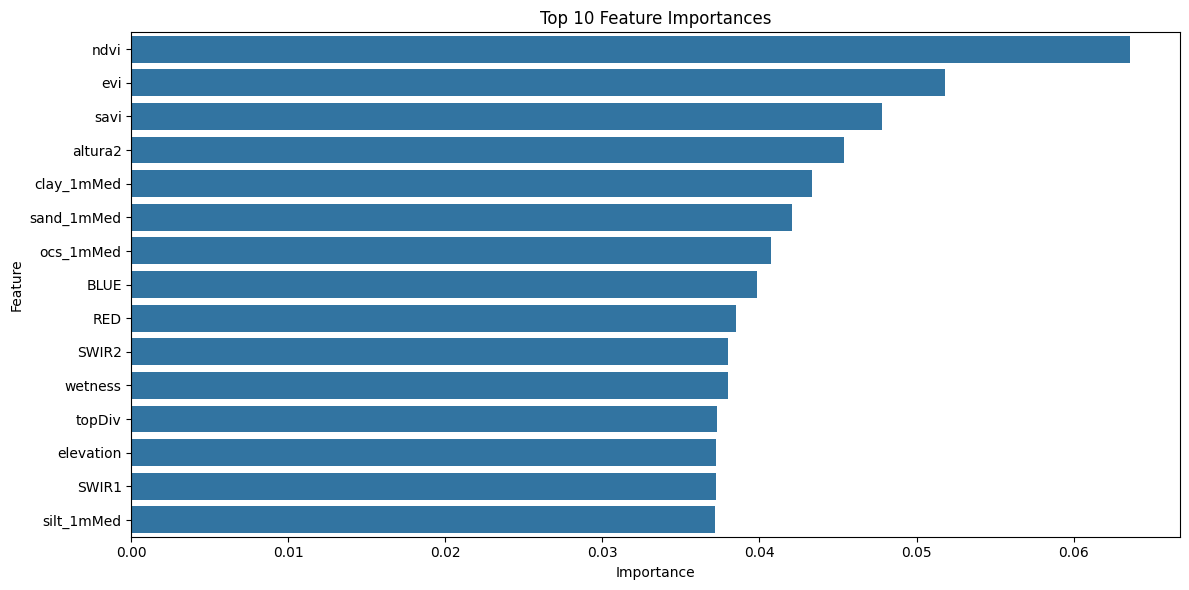

In [55]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


target = 'CoverType'


drop_cols = compressed_data.select_dtypes(exclude='number').columns
features = compressed_data.drop(columns=drop_cols.tolist() + [target])

X = features
y = compressed_data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


print(f"Training Accuracy: {model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.2f}")


importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


## Using a simple Random forest model to filter and rank features.We see that the top features to be selected are ndvi,evi,savi,sand_1mMed,clay_1mMed,RED,ocs_1mMed,BLUE,SWIR2,elevation.

## Recursive Feature Elimination (RFE)

In [56]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rfe = RFE(estimator=RandomForestClassifier(n_estimators=100))
rfe.fit(X, y)
# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)
print("Optimal number of features:", rfe.n_features_)

Selected Features: Index(['BLUE', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'clay_1mMed', 'elevation',
       'evi', 'ndvi', 'sand_1mMed', 'savi', 'silt_1mMed', 'topDiv', 'wetness'],
      dtype='object')
Optimal number of features: 14


## Simple correlation adided in the inital filtering, RFE was computationally costly to run however gave us a fine-tuned subset of variables to work with. Random Forest feature importance graph give more interpretability and a smaller subset of features. This approach offered the most practical and useful feature selection approach.

## Modeling 

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [58]:
pred=compressed_data[['BLUE', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'clay_1mMed', 'elevation','evi', 'ndvi', 'sand_1mMed', 'savi', 'silt_1mMed', 'topDiv', 'wetness']]
target=compressed_data['CoverType']
     

In [62]:
from sklearn.impute import SimpleImputer
import numpy as np

# Handle NaNs in pred (i.e. X)
imputer = SimpleImputer(strategy='mean')  # or 'median', etc.
X = imputer.fit_transform(pred)

y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = []
models.append(('LG', LogisticRegression()))
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('MLP', MLPRegressor()))
models.append(('XGBoost', XGBRegressor()))

In [ ]:
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, mean_squared_error
from math import sqrt

results = []
models_stats = []
names = []
scoring = 'neg_mean_absolute_error' # Change to 'r2' for R2, 'neg_mean_squared_error' for MSE, or 'neg_root_mean_squared_error' for RMSE

for name, model in tqdm(models):
    start = time.time()
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    model.fit(X_train, y_train)
    train_time = time.time() - start
    cv_results = -1 * cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)

    # Make predictions
    start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    # Coefficients are not available for all models
    if hasattr(model, 'coef_'):
        print(f"Coefficients for {name}: ", model.coef_)

    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print("\tMean Squared Error:", mean_squared_error(y_test, y_pred))
    print("\tRoot Mean Squared Error:", sqrt(mean_squared_error(y_test, y_pred)))
    print()

    model_stats = {
        'name': name,
        'mean_score': cv_results.mean(),
        'std_score': cv_results.std(),
        'explained_variance': explained_variance_score(y_test, y_pred),
        'mean_absolute_error': mean_absolute_error(y_test, y_pred),
        'r2_score': r2_score(y_test, y_pred),
        'mean_squared_error': mean_squared_error(y_test, y_pred),
        'root_mean_squared_error': sqrt(mean_squared_error(y_test, y_pred)),
    }

    models_stats.append(model_stats)

# Boxplot to compare algorithms
fig = pyplot.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation = 45)
pyplot.show()

# Sorting the models based on mean absolute error
models_stats.sort(key=lambda x: x['mean_absolute_error'])

print("\nModels performance:")
for model in models_stats:
    print(f"{model['name']} - Mean Absolute Error: {model['mean_absolute_error']}")

  0%|          | 0/12 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Coefficients for LG:  [[ 4.14862999e-07  3.49405280e-06  6.42535897e-07  2.74881494e-06
   1.33616403e-06  5.82793920e-03 -1.40607444e-04  2.60867059e-06
  -1.62296892e-06 -6.01628889e-05  1.68370221e-06  5.94730835e-04
  -3.16212517e-03 -9.42563899e-07]
 [ 7.36934394e-08 -3.20985538e-06  1.95746385e-06  2.88393004e-06
   3.41480106e-06 -1.29097003e-03  5.19390453e-04 -1.17870304e-05
  -1.39810671e-05 -1.62624160e-04 -8.56140944e-06 -1.64057978e-03
  -8.76487044e-04 -3.85183222e-06]
 [ 8.50778901e-05 -2.20892538e-04  1.93216364e-04  2.41595592e-04
   2.45934503e-04 -4.03506011e-04  2.21046039e-04 -8.25290529e-04
  -1.11594825e-03  1.47493378e-03 -6.85174045e-04 -5.28419631e-03
   2.14742195e-03 -2.60809735e-04]
 [-6.55465777e-07  9.48731117e-08 -1.55057305e-06 -7.27456731e-07
  -1.36907981e-06 -2.53644357e-03  1.04950623e-04  4.56686191e-06
   2.93719968e-06  1.72059243e-04  2.79684664e-06  6.92656511e-03
  -2.23624660e-03  3.55111099e-07]
 [-8.44027637e-05  3.99798440e-04 -1.93418399e

 25%|██▌       | 3/12 [01:07<02:17, 15.24s/it]

Coefficients for LR:  [-6.77687613e+00 -1.23686614e+01 -2.12949037e+01  3.17766538e+01
  1.16751626e+01  2.12068416e-04 -6.43168139e-06 -9.85589461e-04
  4.26161833e-01  2.32766335e-04 -1.73738273e+00  5.27303485e-04
  9.20696074e-02  4.03522498e+01]
LinearRegression()
	Training time: 0.060s
	Prediction time: 0.000s
	Explained variance: 0.11132950999161273
	Mean absolute error: 0.20592580880576586
	R2 score: 0.11132524238586416
	Mean Squared Error: 0.21646385168842633
	Root Mean Squared Error: 0.46525675888527007

Coefficients for Ridge:  [ 7.48865856e-01  1.37010949e+00 -3.18687868e+00  3.22844922e+00
 -4.55960950e+00  2.10612809e-04 -2.46851112e-05 -7.58416819e-04
  4.95668975e-01  2.45111759e-04 -1.65236434e+00  5.22307180e-04
  8.83909096e-02  1.90906564e+00]
Ridge()
	Training time: 0.017s
	Prediction time: 0.000s
	Explained variance: 0.10488188133762621
	Mean absolute error: 0.2068054794795104
	R2 score: 0.10487610793542534
	Mean Squared Error: 0.21803473515421354
	Root Mean Squar

 42%|████▏     | 5/12 [01:08<00:42,  6.07s/it]

Coefficients for Lasso:  [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  2.55465469e-04  1.98923878e-06  0.00000000e+00
  0.00000000e+00  3.19460201e-04  0.00000000e+00  4.82862027e-04
  0.00000000e+00  0.00000000e+00]
Lasso()
	Training time: 0.360s
	Prediction time: 0.001s
	Explained variance: 0.018148411720956825
	Mean absolute error: 0.21569372679081808
	R2 score: 0.018147535497640588
	Mean Squared Error: 0.23916012515822793
	Root Mean Squared Error: 0.4890400036379723

Coefficients for ElasticNet:  [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  3.14069348e-04  2.42810911e-06  0.00000000e+00
  0.00000000e+00  3.96523390e-04  0.00000000e+00  5.73635201e-04
  0.00000000e+00  0.00000000e+00]
ElasticNet()
	Training time: 0.009s
	Prediction time: 0.000s
	Explained variance: 0.019477407232390442
	Mean absolute error: 0.21471092056095642
	R2 score: 0.019476255051987135
	Mean Squared Error: 0.2388364749700311
	Root Mean 

 50%|█████     | 6/12 [01:10<00:28,  4.75s/it]

KNeighborsRegressor()
	Training time: 0.135s
	Prediction time: 0.162s
	Explained variance: 0.25810380638473274
	Mean absolute error: 0.14718233246301132
	R2 score: 0.25810366596269396
	Mean Squared Error: 0.18071148825065278
	Root Mean Squared Error: 0.4251017387057512



 58%|█████▊    | 7/12 [01:33<00:53, 10.66s/it]

DecisionTreeRegressor()
	Training time: 2.399s
	Prediction time: 0.003s
	Explained variance: -0.43873309924801274
	Mean absolute error: 0.16367493472584857
	R2 score: -0.43926370262790826
	Mean Squared Error: 0.35057658833768496
	Root Mean Squared Error: 0.5920950838654928

